# Proyecto Final

Integrantes:
- Kroko
- Alan
- Nandy

### Enunciado

En este proyecto tendrá que trabajar con datos reales del departamento de la policía de la ciudad de nueva york y se enmarca en el contexto de seguridad y criminalidad en los barrios de la ciudad. **El objetivo de este proyecto es predecir la cantidad de delitos cada cierto tipo por barrio.**





El conjunto de datos a utilizar proviene de la página de datos abiertos de la ciudad de NY. (https://opendata.cityofnewyork.us) y comprenden datos desde el 2013 hasta el 2020 de arrestos, colisiones vehiculares y denuncias ciudadanas.

El dataset contiene diversos registros de distintos tipos de crimenes, en este estudio debe centrarse en los siguientes:
1. Delitos (Felonies)
2. Faltas (Misdemeanors)
3. Violaciones (Violations)

Esta categorización puede ser encontrada en la variable "LAW_CAT_CD"

Los barrios de estudio son:
- Staten Island
- Brooklyn
- Queens
- Manhattan
- Bronx

### Requerimientos



1. Seleccione al menos dos barrios de la ciudad y obtenga estimaciones de la cantidad de delitos, por tipo, ocurridos en la ciudad de NY semana a semana usando como conjunto de entrenamiento toda la data hasta el 2019 y como conjunto de pruebas el año 2020 completo. Compare distintas aproximaciones de modelamiento utilizando las métricas y modelos vistos en clases aunque se permite tambien usar métricas/modelos no discutidos (siempre y cuando se utilicen de manera correcta).
2. Deberá almacenar la informacion en una base de datos Postgres con el esquema de datos que usted prefiera
3. Utilizando Apache Airflow, cree un DAG que contenga al menos las siguientes tasks:
    - Data Processing: Extraerá la informacion de la based de datos Postgres
    - Data Processing: Procesará la informacióin extraida en la etapa anterior realizando todas las tareas de ingeniería de atributos que usted estime conveniente para sus modelos
    - Model Training: Utilizando la información generada en el punto anterior esta tasa debe ajustar los modelos a la data histórica con los hiperparámetros y configuración que usted haya estimado conveniente de su experimentación previa, una vez finalizado el entrenamiento debe almacenar el modelo donde usted estime conveniente. Este paso se debe realizar solo si no existe un modelo previamente entrenado, en cuyo caso se debe omitir este paso y pasar directamente al siguiente.
    - Model Inference: Utilizando un modelo ya entrenado, realice inferencias sobre el conjunto de pruebas y estas sean guardadas en una tabla de postgres.

4. Genere un informe breve donde se explique la metodología que utilizó para realizar los modelos justificando las decisiones tomadas a partir de lo observado en la experimientación. Explique tambien la infraestructura y el DAG generado.

### Consideraciones:


- Se recomienda realizar la experimentación sobre los datos en Jupyter para determinar la mejor configuración de los modelos de series de tiempo, una vez que haya obtenido un modelo con resultados satisfactorios incluya esta configuración en la tasa de Model Training.
- Sus modelos deben hacer predicciones a nivel semana, es decir, debe ser capaz de entregar para cada semana del 2020 disponible en los datos la cantidad de delitos de cada tipo que ocurrirán por barrio.
- Note que no se especificó la forma en que se debe pasar la informacion de una task a la siguiente, esto queda a criterio del equipo ya que hay muchas formas de hacerlo. Estudie e investigue cual es la que más le conviene para su caso o considear que es correcta. Lo mismo para el modelo en si.
- El entregable subido a aula debe contener al menos el notebook con los experimentos realizados, al menos un archivo .py con la definicion del DAG/tasks, el informe en formato PDF, un dump de la base de datos en formato .sql con las tablas que haya utilizado ya pobladas junto con un archivo en formato .txt o .json con la información necesaria para conectarse a la base de datos, y en caso de ser necesario, el modelo entrenado.
- Puesto que le pide usar una base de datos para almacenar la informacion durante las tasks necesitará hacer una conexión desde Python a Postgres: Queda prohibido incluir información sensible sobre la conexión al motor en los archivos .py, se le sugiere crear un archivo de configuracion en formato .json  (o el que guste) y que este sea leido simplemente desde el codigo, demas esta decir que si usa alguna herramienta de versionamiento de codigo ese archivo no deberia ser subido aunque para los efectos de la tarea subalo junto con el resto de los entregables. 
- Entregar codigo con informacion sensible sobre las conexiones al motor incurrirá en descuentos de puntaje
- Algo que le sera util es usar Docker.
- Este proyecto puede ser realizado en grupos de máximo tres personas.

## Pregunta 1: 

Selección de barrios y exploración de datos

In [1]:
import pandas as pd
import sklearn
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

Seleccionamos del dataset aquellos registros de 2019 y 2020 para su posterior uso

In [7]:
# ya que debemos ocupar el 2019 como entrenamiento, y el 2020 como prueba, vamos a sacar slices de la data.

df = pd.read_csv("./Data/NYPD_Arrests_Data__Historic_.csv")
df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,32311380,06/18/2007,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,Q,27,1.0,18-24,M,BLACK,NaN,NaN,NaN,NaN,NaN
1,192799737,01/26/2019,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,F,M,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045)
2,193260691,02/06/2019,NaN,NaN,NaN,NaN,PL 2203400,F,M,14,0.0,25-44,M,UNKNOWN,986685.0,215375.0,40.757839,-73.991212,POINT (-73.99121211099998 40.75783900300007)
3,149117452,01/06/2016,153.0,RAPE 3,104.0,RAPE,PL 1302503,F,K,67,0.0,25-44,M,BLACK,998032.0,175598.0,40.648650,-73.950336,POINT (-73.95033556299995 40.648650085000035)
4,190049060,11/15/2018,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,K,77,0.0,25-44,M,BLACK,1003606.0,185050.0,40.674583,-73.930222,POINT (-73.93022154099998 40.67458330800008)


In [8]:
df["ARREST_DATE"] = pd.to_datetime(df["ARREST_DATE"])
df_2019 = df[df["ARREST_DATE"].dt.year == 2019]
df_2020 = df[df["ARREST_DATE"].dt.year == 2020]
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214617 entries, 1 to 215272
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ARREST_KEY         214617 non-null  int64         
 1   ARREST_DATE        214617 non-null  datetime64[ns]
 2   PD_CD              214576 non-null  float64       
 3   PD_DESC            214458 non-null  object        
 4   KY_CD              214458 non-null  float64       
 5   OFNS_DESC          214458 non-null  object        
 6   LAW_CODE           214617 non-null  object        
 7   LAW_CAT_CD         213248 non-null  object        
 8   ARREST_BORO        214617 non-null  object        
 9   ARREST_PRECINCT    214617 non-null  int64         
 10  JURISDICTION_CODE  214617 non-null  float64       
 11  AGE_GROUP          214617 non-null  object        
 12  PERP_SEX           214617 non-null  object        
 13  PERP_RACE          214617 non-null  object  

In [9]:
## Lo guardamos en un CSV para su manipulación:

df_2019.to_csv("./Data/NYPD_ARRESTS_DATA_2019.csv", index=False)
df_2020.to_csv("./Data/NYPD_ARRESTS_DATA_2020.csv", index=False)

### EDA:

In [14]:
## Revisamos los datasets para Train y Test

df_2019 = pd.read_csv("./Data/NYPD_ARRESTS_DATA_2019.csv")
df_2020 = pd.read_csv("./Data/NYPD_ARRESTS_DATA_2020.csv")

print("Train data: ", df_2019.shape)
print("Test data: ",df_2020.shape)

Train data:  (214617, 19)
Test data:  (140413, 19)


Data Cleaning:

In [24]:
print("Train missing values:")
print(df_2019.isnull().sum())
print()
print("Test missing values:")
print(df_2020.isnull().sum())
print()
print("Train duplicated: ", df_2019.duplicated().sum())
print("Test duplicated: ", df_2020.duplicated().sum())

Train missing values:
ARREST_KEY              0
ARREST_DATE             0
PD_CD                  41
PD_DESC               159
KY_CD                 159
OFNS_DESC             159
LAW_CODE                0
LAW_CAT_CD           1369
ARREST_BORO             0
ARREST_PRECINCT         0
JURISDICTION_CODE       0
AGE_GROUP               0
PERP_SEX                0
PERP_RACE               0
X_COORD_CD              0
Y_COORD_CD              0
Latitude                0
Longitude               0
Lon_Lat                 0
dtype: int64

Test missing values:
ARREST_KEY              0
ARREST_DATE             0
PD_CD                  23
PD_DESC                37
KY_CD                  37
OFNS_DESC              37
LAW_CODE                0
LAW_CAT_CD           1389
ARREST_BORO             0
ARREST_PRECINCT         0
JURISDICTION_CODE       0
AGE_GROUP               0
PERP_SEX                0
PERP_RACE               0
X_COORD_CD              0
Y_COORD_CD              0
Latitude                0
Longitu

In [21]:
df_2019.dtypes

ARREST_KEY             int64
ARREST_DATE           object
PD_CD                float64
PD_DESC               object
KY_CD                float64
OFNS_DESC             object
LAW_CODE              object
LAW_CAT_CD            object
ARREST_BORO           object
ARREST_PRECINCT        int64
JURISDICTION_CODE    float64
AGE_GROUP             object
PERP_SEX              object
PERP_RACE             object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
Lon_Lat               object
dtype: object

In [29]:
# Convertiremos estos datos en algo legible a continuacion:

df_2019["LAW_CAT_CD"] = df_2019["LAW_CAT_CD"].replace({"F": "Felony", "M": "Misdemeanor", "V": "Violation"})
df_2020["LAW_CAT_CD"] = df_2020["LAW_CAT_CD"].replace({"F": "Felony", "M": "Misdemeanor", "V": "Violation"})
print(df_2019["LAW_CAT_CD"].value_counts())
df_2019.head()


Misdemeanor    126609
Felony          83384
Violation        2822
I                 433
Name: LAW_CAT_CD, dtype: int64


,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,192799737,2019-01-26,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,Felony,M,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045)
1,193260691,2019-02-06,NaN,NaN,NaN,NaN,PL 2203400,Felony,M,14,0.0,25-44,M,UNKNOWN,986685.0,215375.0,40.757839,-73.991212,POINT (-73.99121211099998 40.75783900300007)
2,196324211,2019-04-23,157.0,RAPE 1,104.0,RAPE,PL 1303501,Felony,K,77,0.0,45-64,M,BLACK HISPANIC,1003606.0,185050.0,40.674583,-73.930222,POINT (-73.93022154099998 40.67458330800008)
3,196785901,2019-05-04,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 13052A1,Misdemeanor,B,50,0.0,25-44,M,BLACK,1011257.0,261130.0,40.883383,-73.902333,POINT (-73.90233330899997 40.88338257900006)
4,197554056,2019-05-23,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 13052A1,Misdemeanor,M,26,0.0,45-64,F,BLACK,996241.0,236149.0,40.814850,-73.956682,POINT (-73.95668184799996 40.81485028900005)


Ahora si, la 1


In [34]:
train_data = df_2019.copy()
train_data['ARREST_DATE'] = pd.to_datetime(train_data['ARREST_DATE'])

test_data = df_2020.copy()
test_data['ARREST_DATE'] = pd.to_datetime(test_data['ARREST_DATE'])


train_arrest_count = train_data.groupby([pd.Grouper(key='ARREST_DATE', freq='M'), 'LAW_CAT_CD', 'ARREST_BORO']).size().reset_index(name='ARREST_COUNT')
train_arrest_pivot = train_arrest_count.pivot(index='ARREST_DATE', columns=['LAW_CAT_CD', 'ARREST_BORO'], values='ARREST_COUNT')

test_arrest_count = test_data.groupby([pd.Grouper(key='ARREST_DATE', freq='M'), 'LAW_CAT_CD', 'ARREST_BORO']).size().reset_index(name='ARREST_COUNT')
test_arrest_pivot = test_arrest_count.pivot(index='ARREST_DATE', columns=['LAW_CAT_CD', 'ARREST_BORO'], values='ARREST_COUNT')

In [30]:
%pip install statsmodels
%pip install prophet

     ---------------------------------------- 9.2/9.2 MB 11.3 MB/s eta 0:00:00
     ------------------------------------- 233.8/233.8 kB 14.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     --------------------------------------- 12.9/12.9 MB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 83.2/83.2 kB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 47.9/47.9 kB ? eta 0:00:00
     -------------------------------------- 598.5/598.5 kB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.4/1.4 MB 10.0 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732051 sha256=99c7f8dcabf32e83578f34b17864631ba93b7a6dceee493ddd4db513dd5b03a8
  Stored in directory: c:\users\n3mes\appdata\lo

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Example for modeling arrests for Felony offenses in Manhattan
data = train_arrest_pivot[('ARREST_COUNT', 'Felony', 'M')]

# Fit the ARIMA model
model = ARIMA(data, order=(p, d, q))  # Replace p, d, q with appropriate values
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start='2020-01-01', end='2020-12-01', dynamic=True)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example for modeling arrests for Misdemeanor offenses in Brooklyn
data = train_arrest_pivot[('ARREST_COUNT', 'Misdemeanor', 'B')]

# Fit the SARIMA model
model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))  # Replace p, d, q, P, D, Q, S with appropriate values
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start='2020-01-01', end='2020-12-01', dynamic=True)


In [39]:
from prophet import Prophet

# Example for modeling arrests for Violation offenses in Queens
data = train_arrest_pivot[('ARREST_COUNT', 'Violation', 'Q')]

# Prepare the data in a Prophet-compatible format
df = pd.DataFrame({'ds': data.index, 'y': data.values})

# Fit the Prophet model
model = Prophet()
model.fit(df)

# Make future predictions
future_dates = pd.date_range(start='2020-01-01', end='2020-12-01', freq='M')
future = pd.DataFrame({'ds': future_dates})
forecast = model.predict(future)


c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


KeyError: 'Key length (3) exceeds index depth (2)'

Hyperparameter Tuning for models!

In [59]:
train_arrest_pivot
print(train_arrest_pivot.columns.names)

['LAW_CAT_CD', 'ARREST_BORO']


12


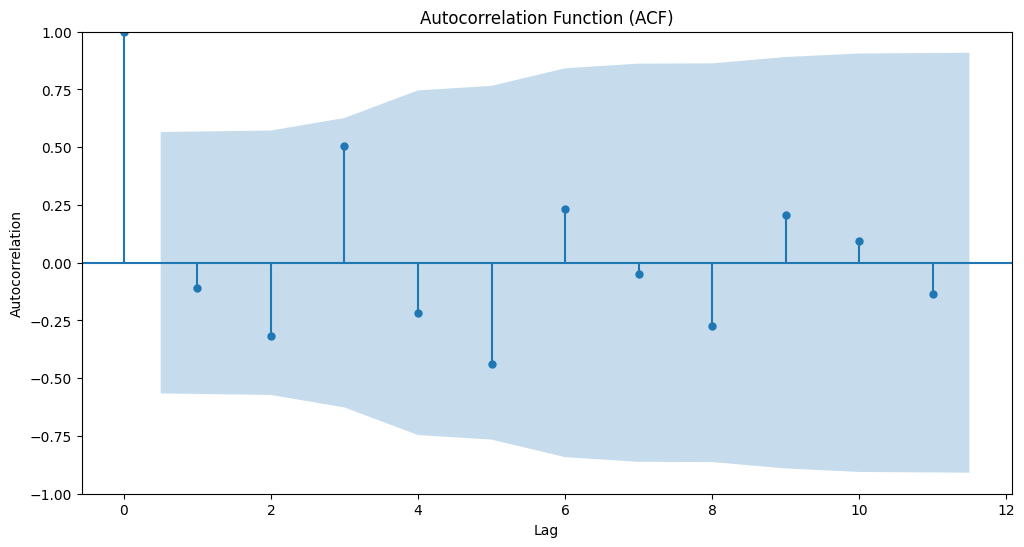

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 11 must be < 6.

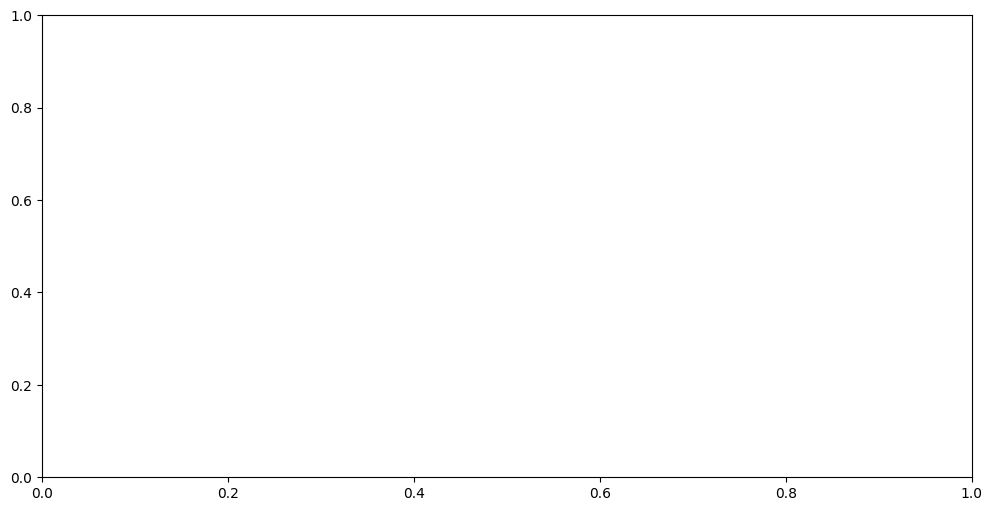

In [63]:
## ARIMA Hyperparameter Tuning

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data in a pandas DataFrame
data = train_arrest_pivot.xs(('Felony', 'M'), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
print(len(data))

# Plot ACF and PACF to identify initial parameter values
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(data, lags=11, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(data, lags=11, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Define a function to evaluate ARIMA models and return AIC and BIC
def evaluate_arima_model(order):
    model = sm.tsa.ARIMA(data, order=order)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    return aic, bic

# Define ranges for p, d, and q
p_values = range(0, 4)  # Example range for p
d_values = range(0, 2)  # Example range for d
q_values = range(0, 4)  # Example range for q

best_aic = float('inf')
best_bic = float('inf')
best_order = None

# Iterate over all possible combinations of p, d, and q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                aic, bic = evaluate_arima_model(order)
                if aic < best_aic:
                    best_aic = aic
                    best_bic = bic
                    best_order = order
            except:
                continue

print("Best AIC:", best_aic)
print("Best BIC:", best_bic)
print("Best Order:", best_order)


['ARREST_DATE']
DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='ARREST_DATE', freq=None)
